In [1]:
import os
import os.path as path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
from IPython.core.interactiveshell import InteractiveShell
from tqdm import tqdm as tqdm
import warnings
import scipy
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
import shelve
import tsfresh
from tsfresh.utilities.dataframe_functions import impute
import time

from scipy import signal

InteractiveShell.ast_node_interactivity = "last"


%matplotlib inline
plt.rcParams["figure.figsize"] = [12,4]

%load_ext autoreload
%autoreload 2

trial = 0

C:\Users\AlexisFCote\Anaconda3\envs\SpaceFortress\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Breathing data

Acquisistion à 90 Hz

In [308]:
datapath = 'Data/Experience {}'
def parse_array(string):
    return np.array(string[1:-1].split(',')).astype(int)

In [325]:
ls_bio = []
for experience in [1,2]:
    df_biobreathing = pd.read_csv(path.join(datapath.format(experience), 'BioBreathingRaw.csv')).drop('Unnamed: 0',axis=1)
    np.diff(df_biobreathing.SensorHubTimestampInMillisecond.iloc[:].as_matrix())

    df_biobreathing['parsedArray'] = df_biobreathing.BreathingSampleArray.apply(parse_array)

    df_biobreathing['id'] = experience*10000 + df_biobreathing.participant * 100 + df_biobreathing.game
    ls_bio.append(df_biobreathing)
    
df_biobreathing = pd.concat(ls_bio, ignore_index=True)

## filtering and selection

In [326]:
fs = 90 # hz
nyquist = fs//2
low = 1/50 / nyquist
high = 8 / nyquist
b, a = signal.butter(2, [low, high], btype='band')

In [327]:
signals = []
for idx in set(df_biobreathing['id']):
    sig = np.concatenate(df_biobreathing.parsedArray[df_biobreathing['id'] == idx].as_matrix())
    if 3000 <= len(sig) < 4000:
        centered_filtered = signal.lfilter(b, a, sig - np.mean(sig[:500]))
        signals.append(centered_filtered[-3000::3])
    

In [331]:
np.arange(len(signals))

array([   0,    1,    2, ..., 1180, 1181, 1182])

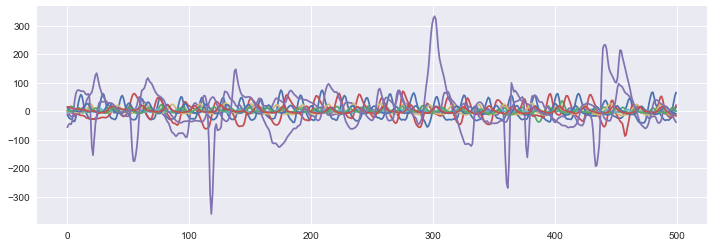

In [334]:
for i in np.random.choice(np.arange(len(signals)), 10):
    plt.plot(signals[i][:500])
plt.show()

## Auto Encoder

In [338]:
from sklearn.model_selection import train_test_split
X = np.array(signals)

signal_len = X.shape[1]

X_train, X_test = train_test_split(X, test_size=0.1)
X_train.shape, X_test.shape

((1064, 1000), (119, 1000))

In [339]:
X_train = np.concatenate([X_train for i in range(5)])
X_train_noise = X_train + np.random.randn(*X_train.shape) * np.std(X_train)

X_test_noise = X_test + np.random.randn(*X_test.shape) * np.std(X_test)

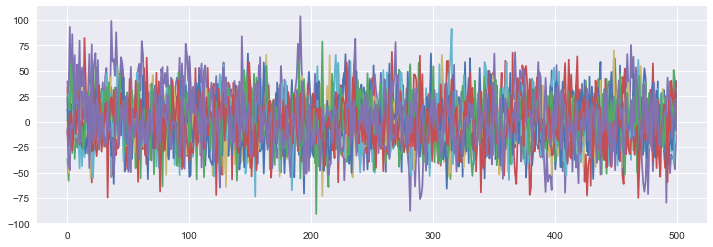

In [340]:
for i in np.random.choice(np.arange(len(signals)), 10):
    plt.plot(X_train_noise[i,:500])
plt.show()

In [341]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = ss.fit_transform(X_train.astype('float32') )
x_train_noise = ss.transform(X_train_noise.astype('float32'))
x_test = ss.transform(X_test.astype('float32'))
x_test_noise = ss.transform(X_test_noise.astype('float32'))
x_train = np.reshape(x_train, (len(x_train), signal_len, 1))
x_train_noise = np.reshape(x_train_noise, (len(x_train_noise), signal_len, 1))
x_test = np.reshape(x_test, (len(x_test), signal_len, 1))
x_test_noise = np.reshape(x_test_noise, (len(x_test_noise), signal_len, 1))

In [360]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D, Flatten, Dense, Reshape
from keras.models import Model
from keras import backend as K

Pooling = AveragePooling1D
activation='relu'

pool_size = [2, 2, 2, 5]
filter_number = [10, 4, 4, 4]
kernel_size = [5, 5, 5, 5]

input_img = Input(shape=(signal_len, 1))  # adapt this if using `channels_first` image data format
x = input_img

for pool_s, filter_n, kernel_s in zip(pool_size, filter_number, kernel_size): 
    x = Conv1D(filters=filter_n, kernel_size=kernel_s, activation=activation, padding='same')(x)
    x = Pooling(pool_size=pool_s, padding='same')(x)

encoded = x

# at this point the representation is ??

for pool_s, filter_n, kernel_s in reversed(list(zip(pool_size, filter_number, kernel_size))): 
    x = Conv1D(filters=filter_n, kernel_size=kernel_s, activation=activation, padding='same')(x)
    x = UpSampling1D(pool_s)(x)

decoded = Conv1D(filters=1, kernel_size=5, activation=None, padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mae')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 1000, 1)           0         
_________________________________________________________________
conv1d_439 (Conv1D)          (None, 1000, 10)          60        
_________________________________________________________________
average_pooling1d_83 (Averag (None, 500, 10)           0         
_________________________________________________________________
conv1d_440 (Conv1D)          (None, 500, 4)            204       
_________________________________________________________________
average_pooling1d_84 (Averag (None, 250, 4)            0         
_________________________________________________________________
conv1d_441 (Conv1D)          (None, 250, 4)            84        
_________________________________________________________________
average_pooling1d_85 (Averag (None, 125, 4)            0         
__________

In [361]:
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
trial += 1
autoencoder.fit(x_train_noise, x_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noise, x_test),
                verbose=0,
                callbacks=[TensorBoard(log_dir='tmp/autoencoder/{}'.format(trial)), ModelCheckpoint('Model {}', save_best_only=True)])

IndexError: tuple index out of range

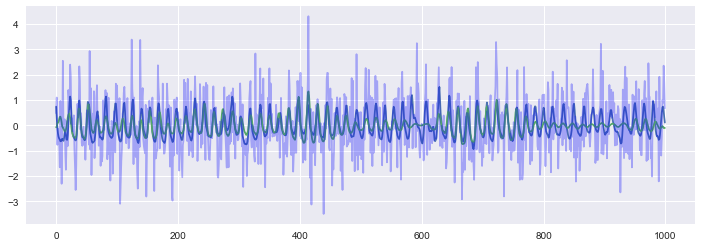

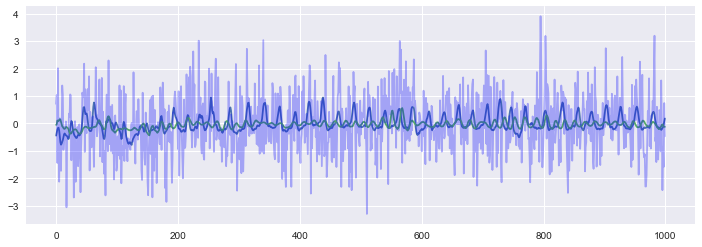

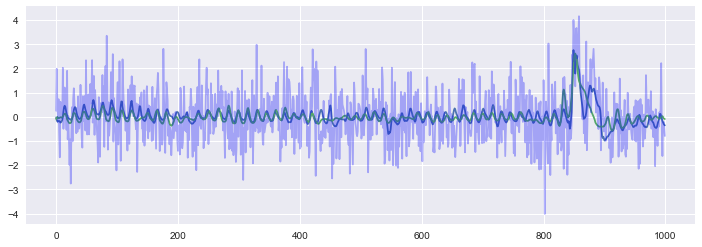

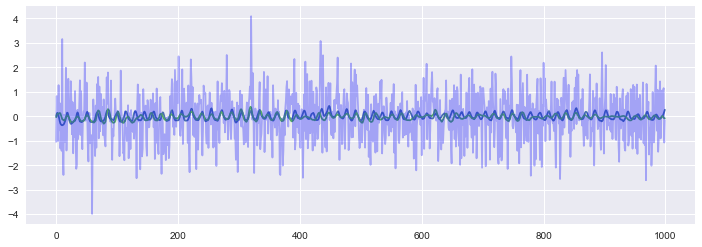

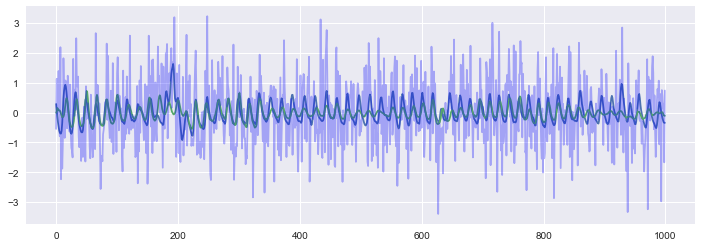

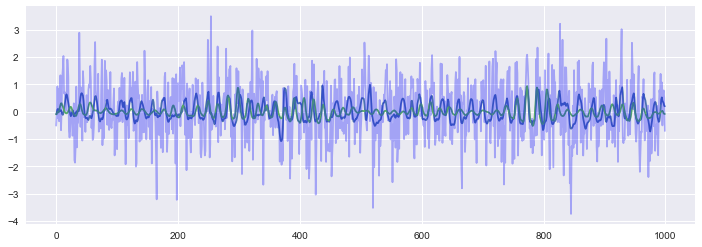

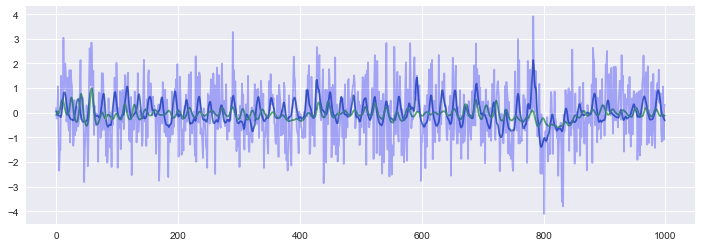

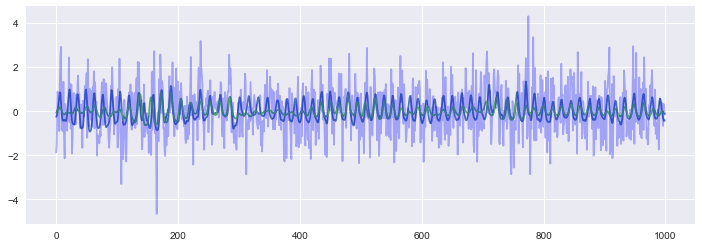

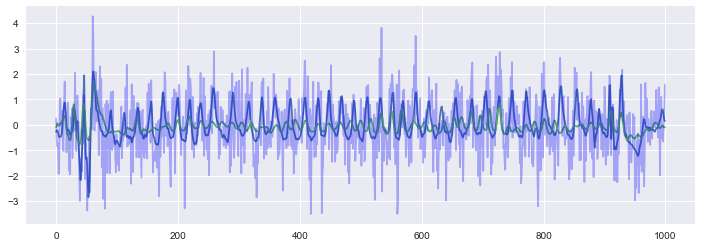

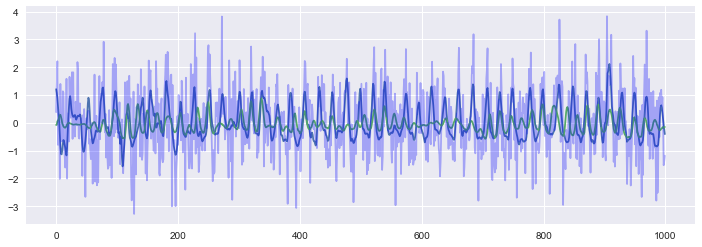

In [344]:
decoded_signals = autoencoder.predict(x_test_noise)

for i in range(10):
    plt.plot(x_test[i,:])
    plt.plot(decoded_signals[i,:])
    plt.plot(x_test_noise[i,:], color='blue', alpha=0.3)
    plt.show()